In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN


# ESTUDO USADO
LINK: https://medium.com/alexandre-george-lustosa/previs%C3%A3o-de-pre%C3%A7o-petr4-com-python-lstm-f93722be59e0

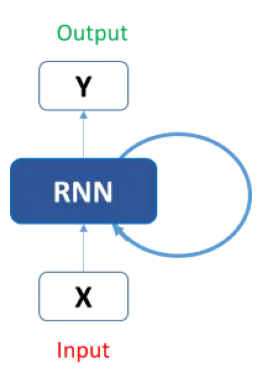

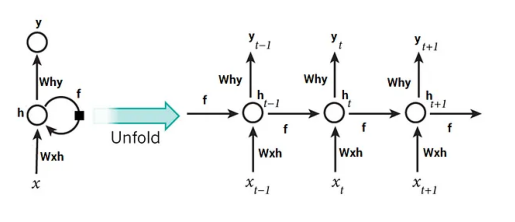

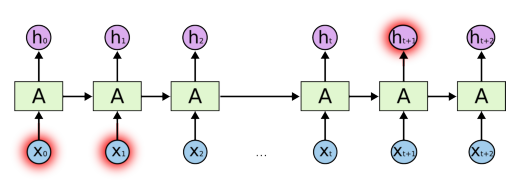

In [59]:
import matplotlib.image as img

imagem = img.imread('rnn.webp')
plt.imshow(imagem)
plt.axis('off')
plt.show()

imagem = img.imread('rnn1.webp')
plt.imshow(imagem)
plt.axis('off')
plt.show()

imagem = img.imread('RNN-longter.png')
plt.imshow(imagem)
plt.axis('off')
plt.show()

# CARREGANDO DADOS

In [60]:
dados = pd.read_csv("PETR4.SA_maior.csv")
dados.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,5.875,5.875,5.875,5.875,1.549026,3.538944e+10
1,2000-01-04,5.550,5.550,5.550,5.550,1.463335,2.886144e+10
2,2000-01-05,5.494,5.494,5.494,5.494,1.448570,4.303360e+10
3,2000-01-06,5.475,5.475,5.475,5.475,1.443560,3.405568e+10
4,2000-01-07,5.500,5.500,5.500,5.500,1.450152,2.091264e+10


# ANALISE GERAL DOS DADOS

In [61]:
dados[dados.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume
1261,2004-11-02,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
dados.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume       float64
dtype: object

In [63]:
dados.describe()

,Open,High,Low,Close,Adj Close,Volume
count,6056.000000,6056.000000,6056.000000,6056.000000,6056.000000,6.056000e+03
mean,19.553724,19.843126,19.244688,19.529602,7.584725,5.362423e+08
std,9.748526,9.898949,9.583916,9.724197,6.230822,3.843433e+09
min,4.200000,4.270000,4.120000,4.200000,1.153530,0.000000e+00
25%,10.684375,10.825000,10.500938,10.674688,3.194001,2.177445e+07
50%,19.915000,20.235000,19.600000,19.920000,6.428870,3.507385e+07
75%,26.702500,27.059999,26.272500,26.712499,9.485749,5.595530e+07
max,67.500000,67.500000,51.950001,52.509998,42.200001,7.356416e+10


In [64]:
for coluna in dados.columns:
    if dados[coluna].dtype == 'object':
        print(f"\nColuna '{coluna}':\nTipos possíveis: {dados[coluna].unique()}")


Coluna 'Date':
Tipos possíveis: ['2000-01-03' '2000-01-04' '2000-01-05' ... '2024-02-08' '2024-02-09'
 '2024-02-14']


# TRATAMENTO DOS DADOS

In [65]:
dados = dados.dropna()
dados[dados.isna().any(axis=1)]

,Date,Open,High,Low,Close,Adj Close,Volume


# VISUALIZANDO DADOS

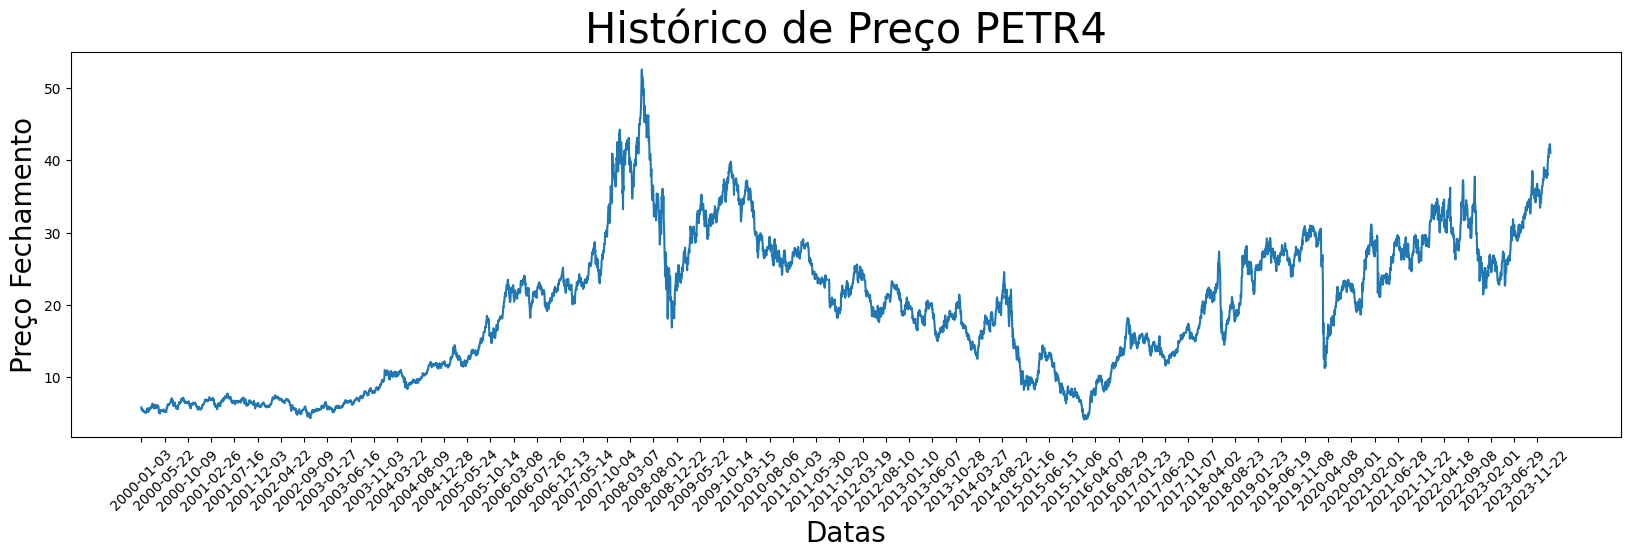

In [66]:
plt.figure(figsize = (20,5))

plt.plot(dados['Close'])
plt.xticks(range(0,dados.shape[0], 100), dados['Date'].loc[::100], rotation=45)

plt.xlabel('Datas', fontsize=20)
plt.ylabel('Preço Fechamento', fontsize=20)
plt.title("Histórico de Preço PETR4", fontsize=30)

plt.show()

In [67]:
days_time_step = 15 # intervalo de dias anterior para estimar os proximos dias
precos = dados['Close']

# SEPARANDO TREINO E TESTE

In [68]:
size_treino = int(len(precos) * 0.90)
size_teste = len(precos) - size_treino

dados_treino, input_data = np.array(precos[0:size_treino]), np.array(precos[size_treino - days_time_step:])
dados_teste = np.array(precos[size_treino:])

print(dados_treino.shape, input_data.shape, dados_teste.shape)

(5450,) (621,) (606,)


In [69]:
dados_treino[:5]

array([5.875, 5.55 , 5.494, 5.475, 5.5  ])

In [70]:
input_data[:5]

array([27.030001, 26.790001, 26.639999, 26.6     , 27.02    ])

In [71]:
dados_teste[:5]

array([24.969999, 25.5     , 25.34    , 26.23    , 25.879999])

# VISUALIZANDO SEPARAÇÃO

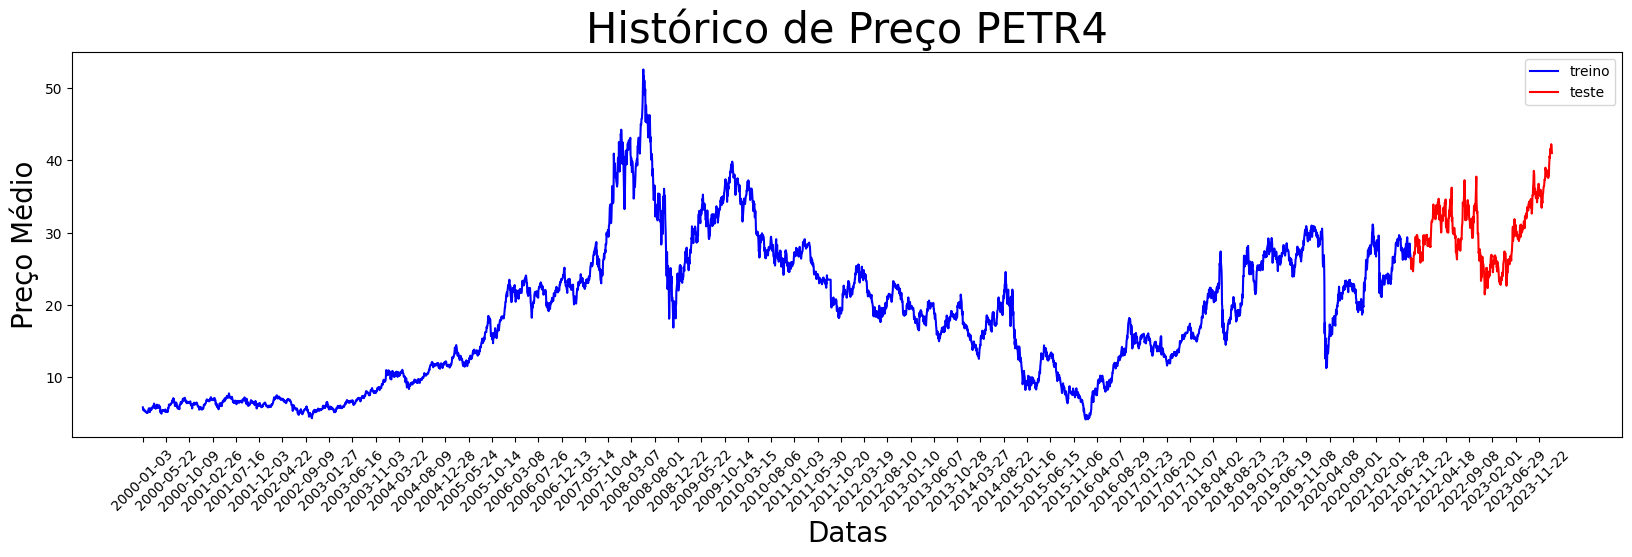

In [72]:
plt.figure(figsize = (20, 5))

plt.plot(dados['Close'].loc[0: dados_treino.shape[0]], color = 'blue', label = 'treino')
plt.plot(dados['Close'].loc[dados_treino.shape[0]: ], color = 'red', label = 'teste')
plt.xticks(range(0, dados.shape[0], 100), dados['Date'].loc[: : 100], rotation=45)

plt.xlabel('Datas', fontsize=20)
plt.ylabel('Preço Médio', fontsize=20)
plt.title("Histórico de Preço PETR4", fontsize=30)

plt.legend()
plt.show()

# NORMALIZANDO DADOS

In [73]:
np.array(dados_treino)

array([ 5.875   ,  5.55    ,  5.494   , ..., 26.6     , 26.33    ,
       26.459999])

In [74]:
np.array(dados_treino).reshape(-1,1)

array([[ 5.875   ],
       [ 5.55    ],
       [ 5.494   ],
       ...,
       [26.6     ],
       [26.33    ],
       [26.459999]])

In [75]:
np.array(dados_teste)

array([24.969999, 25.5     , 25.34    , 26.23    , 25.879999, 26.33    ,
       26.1     , 24.93    , 24.65    , 25.209999, 25.85    , 26.84    ,
       26.9     , 27.139999, 26.959999, 27.389999, 27.23    , 28.      ,
       28.790001, 29.42    , 28.639999, 28.6     , 29.120001, 29.32    ,
       29.629999, 29.68    , 29.6     , 29.450001, 28.01    , 28.5     ,
       27.450001, 27.18    , 29.040001, 28.76    , 28.690001, 28.959999,
       27.15    , 28.      , 26.85    , 26.      , 25.85    , 26.120001,
       26.639999, 26.43    , 26.450001, 26.99    , 27.27    , 26.58    ,
       26.540001, 26.1     , 26.360001, 27.799999, 28.370001, 29.620001,
       28.469999, 29.469999, 29.43    , 29.6     , 28.360001, 28.76    ,
       28.889999, 29.360001, 29.35    , 29.290001, 29.65    , 29.469999,
       29.120001, 29.299999, 29.690001, 28.99    , 28.16    , 28.200001,
       28.16    , 28.33    , 28.75    , 28.780001, 28.540001, 28.450001,
       29.09    , 29.200001, 28.07    , 28.049999, 

In [76]:
scaler = MinMaxScaler(feature_range=(0,1))

dados_treino_norm = scaler.fit_transform(np.array(dados_treino).reshape(-1,1))
dados_teste_norm = scaler.transform(np.array(input_data).reshape(-1,1))
dados_validos_norm = scaler.transform(np.array(dados_teste).reshape(-1,1))

print(dados_treino_norm.shape, dados_treino_norm)

(5450, 1) [[0.03467191]
 [0.02794453]
 [0.02678535]
 ...
 [0.46367214]
 [0.45808323]
 [0.46077417]]


In [77]:
print(dados_teste_norm.shape, dados_teste_norm)

(621, 1) [[0.47257301]
 [0.46760509]
 [0.4645001 ]
 [0.46367214]
 [0.47236599]
 [0.48395779]
 [0.48706274]
 [0.48209482]
 [0.50279447]
 [0.49886152]
 [0.47588495]
 [0.47278   ]
 [0.46367214]
 [0.45808323]
 [0.46077417]
 [0.42993169]
 [0.44090252]
 [0.43759058]
 [0.45601327]
 [0.44876837]
 [0.45808323]
 [0.45332231]
 [0.42910372]
 [0.42330782]
 [0.4348996 ]
 [0.4481474 ]
 [0.46864005]
 [0.46988203]
 [0.47484993]
 [0.47112399]
 [0.48002484]
 [0.47671292]
 [0.49265165]
 [0.50900439]
 [0.52204515]
 [0.5058994 ]
 [0.50507143]
 [0.51583527]
 [0.51997518]
 [0.52639205]
 [0.52742706]
 [0.52577108]
 [0.52266616]
 [0.49285864]
 [0.50300147]
 [0.48126686]
 [0.47567793]
 [0.5141793 ]
 [0.50838338]
 [0.50693442]
 [0.51252329]
 [0.47505694]
 [0.49265165]
 [0.46884705]
 [0.45125235]
 [0.4481474 ]
 [0.45373633]
 [0.4645001 ]
 [0.4601532 ]
 [0.46056721]
 [0.471745  ]
 [0.4775409 ]
 [0.46325814]
 [0.46243018]
 [0.45332231]
 [0.45870424]
 [0.48851169]
 [0.50031054]
 [0.5261851 ]
 [0.50238046]
 [0.5230801

# GERANDO X E Y

In [78]:
#treino
X_train, y_train = [], []
for i in range(days_time_step, len(dados_treino)):
    X_train.append(dados_treino_norm[i-days_time_step:i])
    y_train.append(dados_treino_norm[i])
    
#teste
X_test = []
for i in range(days_time_step, days_time_step + len(dados_teste)):
    X_test.append(dados_teste_norm[i-days_time_step:i])
    
#val
X_val, y_val = [], []
for i in range(days_time_step, len(dados_teste)):
    X_val.append(dados_validos_norm[i-days_time_step:i])
    y_val.append(dados_validos_norm[i])

#converter tudo pra matriz numpy
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
X_val = np.array(X_val)
y_val = np.array(y_val)

print(X_train.shape, X_val.shape, X_test.shape)

(5435, 15, 1) (591, 15, 1) (606, 15, 1)


In [79]:
X_train[:2, :]

array([[[0.03467191],
        [0.02794453],
        [0.02678535],
        [0.02639205],
        [0.02690954],
        [0.0292486 ],
        [0.02639205],
        [0.02655765],
        [0.02328711],
        [0.02483958],
        [0.0235562 ],
        [0.02407369],
        [0.02328711],
        [0.02303871],
        [0.02069965]],

       [[0.02794453],
        [0.02678535],
        [0.02639205],
        [0.02690954],
        [0.0292486 ],
        [0.02639205],
        [0.02655765],
        [0.02328711],
        [0.02483958],
        [0.0235562 ],
        [0.02407369],
        [0.02328711],
        [0.02303871],
        [0.02069965],
        [0.01993376]]])

# CRIANDO ARQUETETURA DA REDE NEURAL RNN

In [80]:
modelo = Sequential()

modelo.add(SimpleRNN(100, return_sequences=False, input_shape=(days_time_step, 1)))
modelo.add(Dense(1))

modelo.compile(loss='mse', optimizer='adam')

modelo.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 100)               10200     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 10301 (40.24 KB)
Trainable params: 10301 (40.24 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
historico = modelo.fit(X_train, y_train, validation_data = (X_val, y_val), epochs=100, batch_size=32)

Epoch 1/100


170/170 [==============================] - 4s 10ms/step - loss: 0.0037 - val_loss: 7.7414e-04
Epoch 2/100
170/170 [==============================] - 1s 6ms/step - loss: 3.8206e-04 - val_loss: 6.3679e-04
Epoch 3/100
170/170 [==============================] - 1s 6ms/step - loss: 3.4631e-04 - val_loss: 6.2590e-04
Epoch 4/100
170/170 [==============================] - 1s 6ms/step - loss: 3.1305e-04 - val_loss: 5.3500e-04
Epoch 5/100
170/170 [==============================] - 1s 6ms/step - loss: 2.5696e-04 - val_loss: 5.1380e-04
Epoch 6/100
170/170 [==============================] - 1s 8ms/step - loss: 2.7411e-04 - val_loss: 4.7114e-04
Epoch 7/100
170/170 [==============================] - 1s 7ms/step - loss: 2.4036e-04 - val_loss: 4.7507e-04
Epoch 8/100
170/170 [==============================] - 1s 7ms/step - loss: 2.1617e-04 - val_loss: 6.1692e-04
Epoch 9/100
170/170 [==============================] - 1s 8ms/step - loss: 2.0493e-04 - val_loss: 3.8093e-04
Epoch 10/100
170/170 [============

# VISUALIZANDO TREINAMENTO

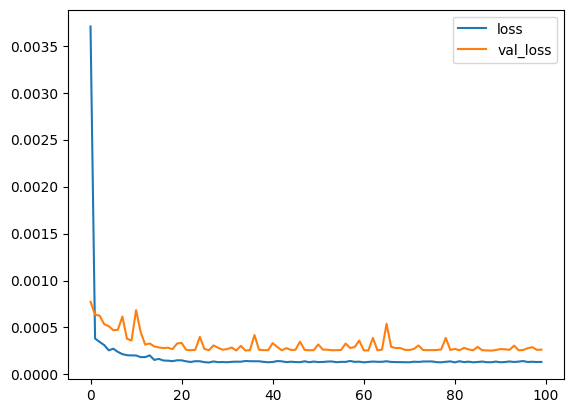

In [82]:
plt.plot(historico.history["loss"], label='loss')
plt.plot(historico.history["val_loss"], label='val_loss')
plt.legend()

# ANALISANDO OS RESULTADOS

In [93]:
#predição de valores pela rede
previsao = modelo.predict(X_test)
previsao[:5]

19/19 [==============================] - 0s 5ms/step


array([[0.45961723],
       [0.4287727 ],
       [0.43572465],
       [0.43892708],
       [0.45607257]], dtype=float32)

In [94]:
#transformação inversa do normalizador, pra que possamos plotar no gráfico os resultados
previsao = scaler.inverse_transform(previsao)
real = dados_teste

print(previsao[:5])
print(real[:5])

[[26.404108]
 [24.914007]
 [25.249857]
 [25.404568]
 [26.232864]]
[24.969999 25.5      25.34     26.23     25.879999]


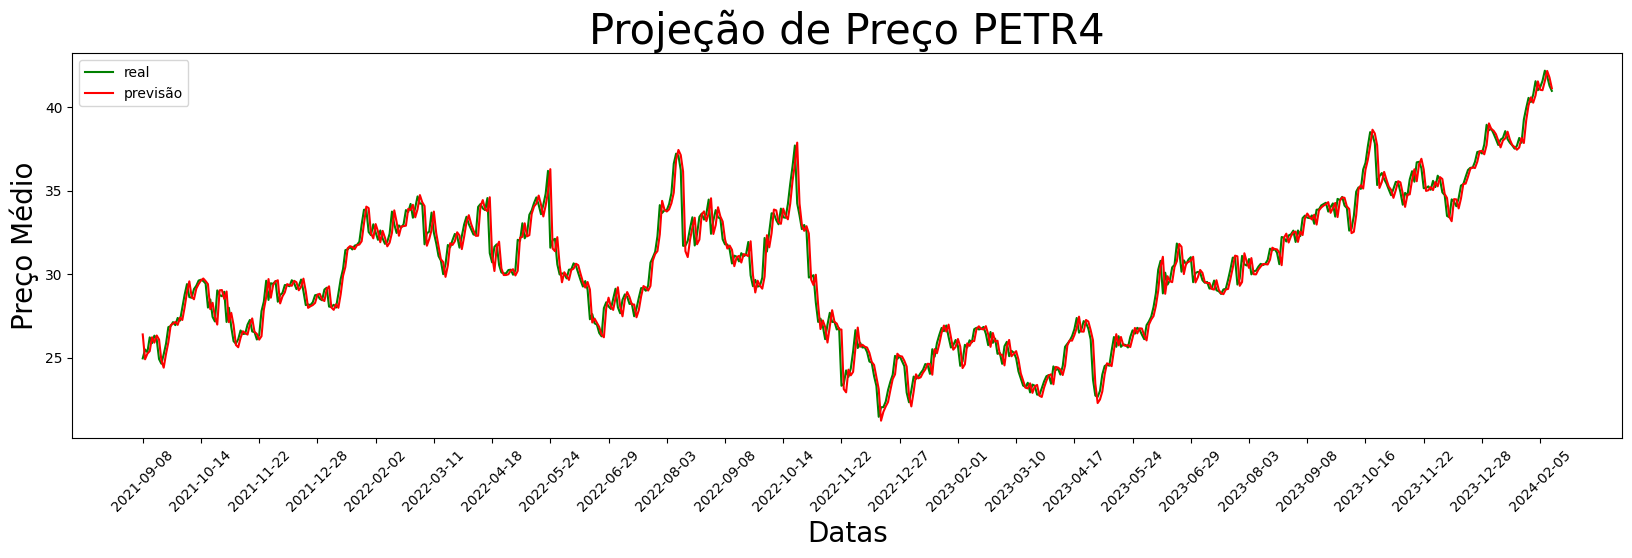

In [97]:
plt.figure(figsize = (20,5))

plt.plot(real, color = 'green', label = 'real')
plt.plot(previsao, color = 'red', label = 'previsão')

plt.xticks(range(0, len(real), 25), dados['Date'].iloc[- len(real)::25], rotation=45)

plt.xlabel('Datas', fontsize=20)
plt.ylabel('Preço Médio', fontsize=20)
plt.title("Projeção de Preço PETR4", fontsize=30)

plt.legend()
plt.show()

In [98]:
import math
from sklearn.metrics import mean_squared_error
mean_squared_error(real, previsao)

0.6113795031638526